# Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

In [1]:
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Optional, Literal

files = {
    'problem1-reg_data.csv':  '1-26J4kn7HVQutjhGkDPUMcSkUZMgjI9K',
    'problem1-auth_data.csv': '1VBOxr_8XM8wfUXHKzaqAZ4uMiozuGTXl'
}

for filename, file_id in files.items():
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, filename, quiet=False)

reg_df  = pd.read_csv('problem1-reg_data.csv', sep=';')
auth_df = pd.read_csv('problem1-auth_data.csv', sep=';')

reg_df['reg_ts']   = pd.to_datetime(reg_df['reg_ts'],  unit='s')
auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts'], unit='s')

Downloading...
From: https://drive.google.com/uc?id=1-26J4kn7HVQutjhGkDPUMcSkUZMgjI9K
To: /content/problem1-reg_data.csv
100%|██████████| 18.0M/18.0M [00:00<00:00, 40.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1VBOxr_8XM8wfUXHKzaqAZ4uMiozuGTXl
From (redirected): https://drive.google.com/uc?id=1VBOxr_8XM8wfUXHKzaqAZ4uMiozuGTXl&confirm=t&uuid=5c25f984-a3a5-460f-80fe-781fc28c50f2
To: /content/problem1-auth_data.csv
100%|██████████| 170M/170M [00:01<00:00, 154MB/s]


In [2]:
# Общая информация о таблицах
print('Registrations:', reg_df.shape)
display(reg_df.head())

print('Auth events:', auth_df.shape)
display(auth_df.head())

# dtypes, пропуски, дубли
def quick_report(df, name):
    print(f'\n{name}')
    display(df.info(show_counts=True))
    print('Nulls per column:')
    display(df.isna().sum())
    print('Duplicate rows:', df.duplicated().sum())

quick_report(reg_df,  'REG TABLE')
quick_report(auth_df, 'AUTH TABLE')

Registrations: (1000000, 2)


,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


Auth events: (9601013, 2)


,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2



REG TABLE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


None

Nulls per column:


,0
reg_ts,0
uid,0


Duplicate rows: 0

AUTH TABLE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype         
---  ------   --------------    -----         
 0   auth_ts  9601013 non-null  datetime64[ns]
 1   uid      9601013 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


None

Nulls per column:


,0
auth_ts,0
uid,0


Duplicate rows: 0


In [3]:
# Уникальные пользователи и пересечение
n_reg_users  = reg_df['uid'].nunique()
n_auth_users = auth_df['uid'].nunique()
n_both       = len(set(reg_df['uid']).intersection(auth_df['uid']))

print(f'Уникальных UID в рег.:  {n_reg_users:,}')
print(f'Уникальных UID в auth: {n_auth_users:,}')
print(f'Пересечение          : {n_both:,}  ({n_both/n_reg_users:.1%} от зарегистр-х)')

Уникальных UID в рег.:  1,000,000
Уникальных UID в auth: 1,000,000
Пересечение          : 1,000,000  (100.0% от зарегистр-х)


In [4]:
# Диапазон дат
def date_span(series):
    return series.min().date(), series.max().date()

reg_min, reg_max   = date_span(reg_df['reg_ts'])
auth_min, auth_max = date_span(auth_df['auth_ts'])

print(f'Registrations: {reg_min} → {reg_max}')
print(f'Auth events : {auth_min} → {auth_max}')

Registrations: 1998-11-18 → 2020-09-23
Auth events : 1998-11-18 → 2020-09-23


In [5]:
reg_df_clean  = reg_df[['uid', 'reg_ts']].copy()
auth_df_clean = auth_df[['uid', 'auth_ts']].copy()

reg_df_clean['reg_date']   = reg_df_clean['reg_ts'].dt.floor('D')
auth_df_clean['auth_date'] = auth_df_clean['auth_ts'].dt.floor('D')

auth_df_clean = auth_df_clean.drop_duplicates(['uid', 'auth_date'])

pairs = (reg_df_clean[['uid', 'reg_date']].merge(auth_df_clean[['uid', 'auth_date']], on='uid', how='inner'))
pairs['days_since'] = (pairs['auth_date'] - pairs['reg_date']).dt.days
pairs = pairs[pairs['days_since'] >= 0]

print('Pairs shape:', pairs.shape)
print('Min/Max days_since:', pairs['days_since'].min(), '/', pairs['days_since'].max())
display(pairs.head())

Pairs shape: (9601013, 4)
Min/Max days_since: 0 / 7729


,uid,reg_date,auth_date,days_since
0,1,1998-11-18,1998-11-18,0
1,2,1999-07-22,1999-07-22,0
2,2,1999-07-22,1999-07-25,3
3,2,1999-07-22,1999-07-31,9
4,2,1999-07-22,1999-08-05,14


In [6]:
def _infer_ts_unit(series: pd.Series) -> Optional[str]:
    if pd.api.types.is_datetime64_any_dtype(series):
        return None
    return 'ms' if series.max() > 1.1e12 else 's'

def calculate_daily_retention(
    df_reg: pd.DataFrame,
    df_auth: pd.DataFrame,
    *,
    start_cohort_date: Optional[str],
    end_cohort_date:   Optional[str],
    retention_days:    List[int],
    return_type:       Literal['percentage', 'ratio'] = 'percentage',
    uid_col:     str = 'uid',
    reg_ts_col:  str = 'reg_ts',
    auth_ts_col: str = 'auth_ts',
) -> pd.DataFrame:

    if not retention_days:
        raise ValueError('retention_days must be non-empty')
    if min(retention_days) < 0:
        raise ValueError('retention_days must be ≥ 0')
    keep_days = sorted(set(retention_days))

    reg_unit  = _infer_ts_unit(df_reg[reg_ts_col])
    auth_unit = _infer_ts_unit(df_auth[auth_ts_col])

    reg  = df_reg[[uid_col, reg_ts_col]].copy()
    auth = df_auth[[uid_col, auth_ts_col]].copy()

    if reg_unit:
        reg_dates = pd.to_datetime(reg[reg_ts_col], unit=reg_unit, utc=True)
    else:
        reg_dates = pd.to_datetime(reg[reg_ts_col], utc=True)
    if auth_unit:
        auth_dates = pd.to_datetime(auth[auth_ts_col], unit=auth_unit, utc=True)
    else:
        auth_dates = pd.to_datetime(auth[auth_ts_col], utc=True)

        reg['reg_date']   = reg_dates.dt.floor('D').dt.tz_localize(None)
    auth['auth_date'] = auth_dates.dt.floor('D').dt.tz_localize(None)


    if start_cohort_date:
        reg = reg[reg['reg_date'] >= pd.to_datetime(start_cohort_date)]
    if end_cohort_date:
        reg = reg[reg['reg_date'] <= pd.to_datetime(end_cohort_date)]
    if reg.empty:
        raise ValueError('No registrations in selected window.')

    cohort_size = reg.groupby('reg_date')[uid_col].nunique().rename('cohort_size')

    auth = auth.drop_duplicates([uid_col, 'auth_date'])
    pairs = (reg.merge(auth, on=uid_col, how='left').dropna(subset=['auth_date']))
    pairs['days_since'] = (pairs['auth_date'] - pairs['reg_date']).dt.days
    pairs = pairs[pairs['days_since'].isin(keep_days)]

    cnt = (pairs.groupby(['reg_date', 'days_since'])[uid_col]
                 .nunique()
                 .unstack(fill_value=0)
                 .reindex(columns=keep_days, fill_value=0))

    retention = cnt.div(cohort_size, axis=0)
    if return_type == 'percentage':
        retention = retention.mul(100).round(2)
    else:
        retention = retention.round(4)

    retention['cohort_size'] = cohort_size.astype(int)
    retention.index.name = 'cohort_date'
    return retention

In [7]:
def plot_retention_triangle(
    df: pd.DataFrame,
    *,
    title: str = 'Cohort retention table',
    cmap: str = 'rocket_r',
    value_type: str = 'ratio',
    annotate: bool = True,
    max_height: int = 14,
    line_width: float = .3,
    ytick_step: int = 1
):

    plot_df = df.copy().fillna(0)

    if value_type == 'ratio':
        annot_fmt = lambda v: f'{v:.2f}'.lstrip('0') if v > 0 else ''
        vmax = plot_df.max().max()
    else:
        annot_fmt = lambda v: f'{v:.0f}%' if v > 0 else ''
        vmax = plot_df.max().max() or 100

    annot = np.vectorize(annot_fmt)(plot_df.values)

    mask = (plot_df == 0)
    for i, idx in enumerate(plot_df.index):
        non_zero_mask = (plot_df.loc[idx] > 0).to_numpy()

        if non_zero_mask.size == 0 or not np.any(non_zero_mask):
            last_valid_col_idx = -1
        else:
            last_valid_col = plot_df.columns[non_zero_mask][-1]
            last_valid_col_idx = plot_df.columns.get_loc(last_valid_col)

        mask.iloc[i, last_valid_col_idx + 1:] = True

    height = min(len(plot_df) * 0.45, max_height)
    width  = len(plot_df.columns) * 0.55 + 4
    plt.figure(figsize=(width, height))

    ax = sns.heatmap(
        plot_df,
        cmap=cmap,
        vmin=0, vmax=vmax,
        annot=annot if annotate else False,
        fmt='',
        mask=mask,
        linewidths=line_width,
        linecolor='white',
        cbar=True,
        cbar_kws={'label': 'Retention' + (' (%)' if value_type == 'percentage' else ' (ratio)')}
    )

    ax.set_title(title, pad=12)
    ax.set_xlabel('Activity, days')
    ax.set_ylabel('Cohort start date')

    yticks_locations = np.arange(len(plot_df.index))[::ytick_step] + 0.5
    yticks_labels = [d.strftime('%Y-%m-%d') for d in plot_df.index][::ytick_step]

    ax.set_yticks(yticks_locations)
    ax.set_yticklabels(yticks_labels, rotation=0)

    plt.tight_layout()
    plt.show()

In [8]:
ret = calculate_daily_retention(
    df_reg          = reg_df,
    df_auth         = auth_df,
    start_cohort_date = '2020-09-01',
    end_cohort_date   = '2020-10-31',
    retention_days    = list(range(1,23)),
    return_type       = 'percentage'
)
display(ret.head())

days_since,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,cohort_size
cohort_date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,2.02,4.10,4.22,4.60,6.43,5.61,6.43,4.10,5.42,5.11,...,4.29,4.41,4.35,5.04,4.16,4.35,3.59,4.35,1.58,1586
2020-09-02,2.52,3.90,4.66,5.67,6.23,7.12,6.30,4.85,4.09,5.67,...,4.97,5.29,4.16,4.85,3.90,3.72,4.66,2.64,0.00,1588
2020-09-03,2.33,5.41,4.71,6.54,6.98,8.55,6.35,5.47,6.29,6.35,...,5.47,5.34,4.40,4.84,4.65,5.47,2.39,0.00,0.00,1591
2020-09-04,2.01,3.64,3.64,5.15,6.40,7.28,4.96,5.34,4.33,5.65,...,4.39,4.52,4.52,4.27,4.77,2.64,0.00,0.00,0.00,1593
2020-09-05,2.76,3.95,4.64,5.45,5.89,7.46,4.89,5.08,5.45,6.02,...,4.51,5.14,4.45,4.76,2.51,0.00,0.00,0.00,0.00,1596


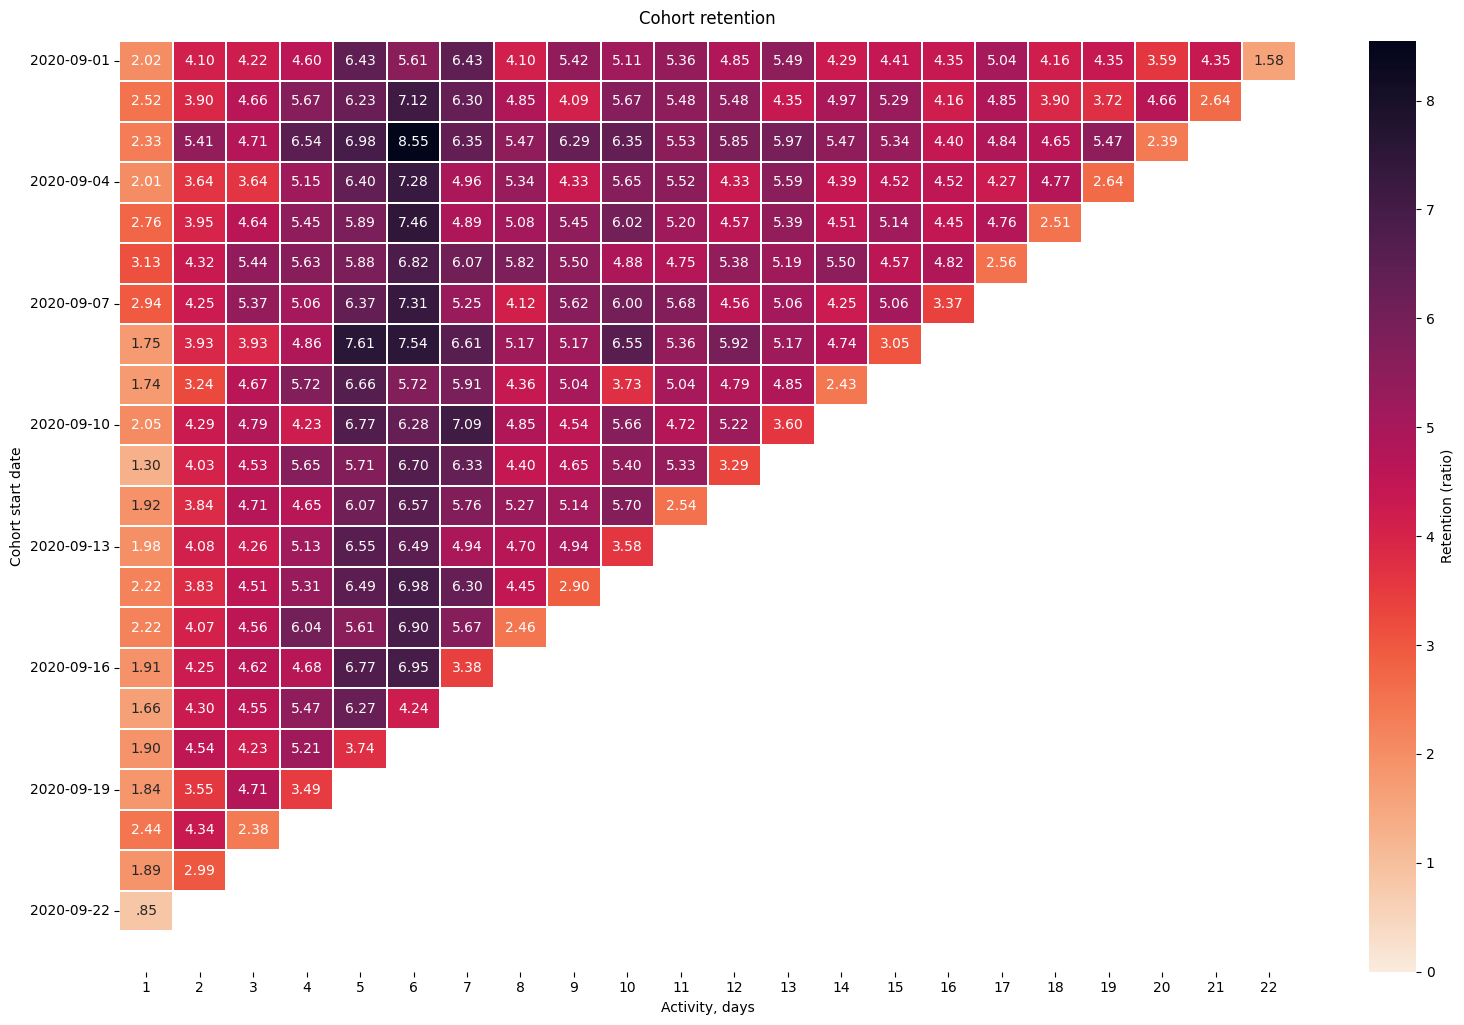

In [9]:
plot_retention_triangle(
    ret.drop(columns='cohort_size'),
    title      = 'Cohort retention',
    value_type = 'ratio',
    ytick_step = 3
)